In [1]:
# 라이브러리
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
import datetime, pytz # to handle time
from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier

In [2]:
# 날짜를 파싱하는 함수를 정의합니다.
def dateparse(date):
    return pd.to_datetime(date)

# 데이터셋을 가져와서 날짜를 인코딩합니다.
df = pd.read_csv('BTC-USD.csv', parse_dates=[0], date_parser=dateparse)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df['Adj Close'].fillna(value=0, inplace=True)
df['Volume'].fillna(value=0, inplace=True)

df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

In [4]:
# 날짜 열을 인덱스로 설정
df.set_index('Date', inplace=True)

In [5]:
# 시작 및 종료 날짜 설정
start = datetime.datetime(2009, 1, 1, 0, 0, 0)
end = datetime.datetime(2020, 10, 17, 20, 0, 0)

In [6]:
# 데이터를 시작 및 종료 날짜에 맞게 필터링
df = df[(df.index >= start) & (df.index <= end)]

In [7]:
# 주간 데이터 생성
weekly_df = df.resample('W-Mon').first()

In [8]:
# NaN 값 처리
weekly_df['Adj Close'].fillna(value=0, inplace=True)
weekly_df['Volume'].fillna(value=0, inplace=True)
weekly_df['Open'].fillna(method='ffill', inplace=True)
weekly_df['High'].fillna(method='ffill', inplace=True)
weekly_df['Low'].fillna(method='ffill', inplace=True)
weekly_df['Close'].fillna(method='ffill', inplace=True)

In [9]:
#주간 데이터에 대한 히스토리컬 데이터 및 레이블 추가
historical_df = weekly_df.copy()
for i in range(1, 8):  # for 7 days
    historical_df["Open_b_" + str(i)] = weekly_df['Open'].shift(i)
    historical_df["High_b_" + str(i)] = weekly_df['High'].shift(i)
    historical_df["Low_b_" + str(i)] = weekly_df['Low'].shift(i)
    historical_df["Close_b_" + str(i)] = weekly_df['Close'].shift(i)
    historical_df["Volume_b_" + str(i)] = weekly_df['Volume'].shift(i)

historical_df = historical_df.dropna()

In [10]:
# 레이블 추가
historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1)
historical_df = historical_df.dropna()

In [11]:
# 데이터 분할
prediction_days = 140
df_train = historical_df.iloc[:-prediction_days]
df_test = historical_df.iloc[-prediction_days:]

In [12]:
# 훈련 및 테스트 데이터 설정
training_set = df_train.values
X_train = training_set[:, 1:-1]
y_train = training_set[:, -1].reshape(-1, 1)

test_set = df_test.values
X_test = test_set[:, 1:-1]
y_test = test_set[:, -1].reshape(-1, 1)

In [16]:
# 모델 훈련
rf = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=5)
rf.fit(X_train, np.ravel(y_train))
predictions = rf.predict(X_test)

In [17]:
# 결과 평가
errors = np.sqrt(mean_squared_error(predictions, y_test))
print('RMSE:', errors)
print('R^2 Score - Coefficient of Determination', rf.score(X_test, y_test))

RMSE: 2003.456197076285
R^2 Score - Coefficient of Determination 0.2412977454650297


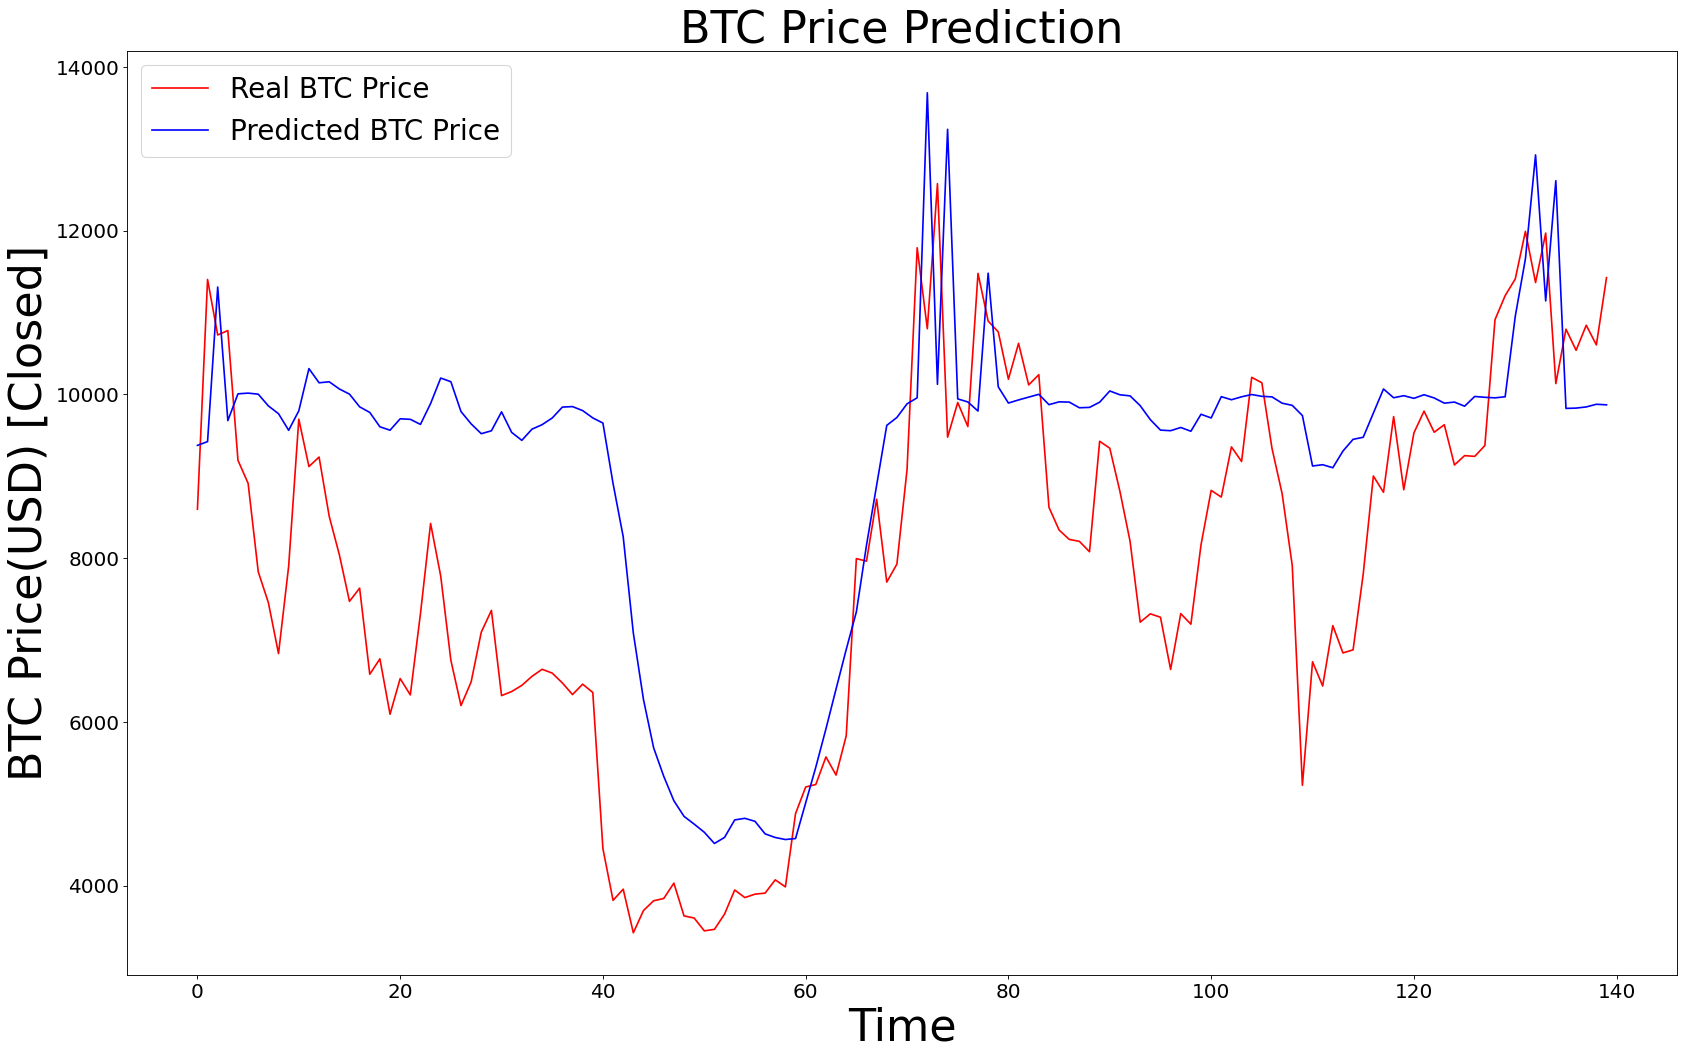

In [18]:
# 결과 시각화
df_Result = pd.DataFrame(y_test, index=df_test.index, columns=["NEXT_CLOSE"])
df_Result['Predicted'] = predictions
df_Result = df_Result.sort_index()

plt.figure(figsize=(25, 15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.plot(df_Result['NEXT_CLOSE'], color='red', label='Real BTC Price')
plt.plot(df_Result['Predicted'], color='blue', label='Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

트리 최대 깊이 조절 (너무 깊게 하면 과적합 일으킬 수 있으므로 적절한 깊이 찾아봐야함)